### Health Insurance Cross Sell Prediction

## Introduction

An Insurance company which provides Health Insurance to its customers needs our help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Goal

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

### Importing Libraries

First I will start with importing libraries

In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score,accuracy_score,confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Can\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Importing the data and checking the values

In [13]:
data = pd.read_csv("healthinsurance.csv")

In [14]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [15]:
data.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [68]:
data.dtypes

Gender                    int32
Age                       int64
Driving_License           int64
Region_Code               int32
Previously_Insured        int64
Vehicle_Damage            int32
Annual_Premium          float64
Policy_Sales_Channel      int32
Vintage                   int64
Response                  int64
(1-2 Year,)             float64
(< 1 Year,)             float64
(> 2 Years,)            float64
dtype: object

As we can see there are some categories and binary variables which is needed to encode in order to feed to the model.

### Data Encoding

In order to feed data to the models variables should be in numeric values. In order to do so I decided to look every column closely and figure out in which way they need to be decoded. 

In [17]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Id column is not needed so I decided to drop.

In [18]:
data = data.drop(["id"],1)

Gender and Vehicle Damage columns are binary so I decided to encode them as 1 and 0. If it comes to gender Female is 1 and Male is 0 and Vehicle Damage, while yes is 1 no is 0.

In [19]:
data.Gender =  np.where(data["Gender"] == "Male", 1, 0)
data.Vehicle_Damage =  np.where(data["Vehicle_Damage"] == "Yes", 1, 0)

Since vehicle Age is some interval I decided to use One hot encoding, to not cause some bias.

In [20]:
ohencoder = OneHotEncoder()
oh_Vehicle_Age = ohencoder.fit_transform(data[["Vehicle_Age"]])
pd.DataFrame(oh_Vehicle_Age.toarray(), columns=ohencoder.categories_).head()
data = data.drop(["Vehicle_Age"],1)
data = data.join(pd.DataFrame(oh_Vehicle_Age.toarray(), columns=ohencoder.categories_))

I changed the types of Region_Code and Policy_Sales_Channel to int32.

In [21]:
data.Region_Code = data.Region_Code.astype('int32')
data.Policy_Sales_Channel = data.Policy_Sales_Channel.astype('int32')

Now the data is ready to split for the benchmark model. Before main model I will do scaling in order to feed to the XGBoost.

In [22]:
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,"(1-2 Year,)","(< 1 Year,)","(> 2 Years,)"
0,1,44,1,28,0,1,40454.0,26,217,1,0.0,0.0,1.0
1,1,76,1,3,0,0,33536.0,26,183,0,1.0,0.0,0.0
2,1,47,1,28,0,1,38294.0,26,27,1,0.0,0.0,1.0
3,1,21,1,11,1,0,28619.0,152,203,0,0.0,1.0,0.0
4,0,29,1,41,1,0,27496.0,152,39,0,0.0,1.0,0.0


### Train & Test splitting

In order to train the random forest I needed to divide the data to train and test and I decided to divide it with 0.8 training and 0.2 test proportion. And I set the random state in order to be able to reproduce the same results.

In [25]:
from sklearn.model_selection import train_test_split

y = data['Response']
x = data.drop(['Response'], axis = 1)

x_train,x_test,y_train,y_test = train_test_split(x, y, random_state = 123, test_size = 0.2)

### Random Forest (Benchmark Model)

Random Forest is an ensemble method that trains several decision trees in parallel with bootstrapping followed by aggregation, jointly referred as bagging. It's pretty straightforward and since I am going to use it as benchmark model I am not going to do any hyperparameter tuning.

In [90]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(x_train,y_train)

y_pred=rfc.predict(x_test)

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93     66897
           1       0.36      0.12      0.18      9325

    accuracy                           0.87     76222
   macro avg       0.62      0.55      0.55     76222
weighted avg       0.82      0.87      0.84     76222



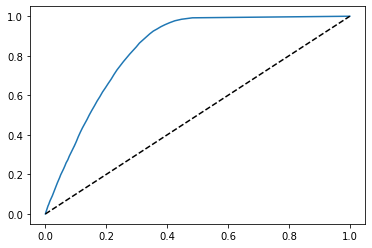

Area under curve (AUC):  0.8334629800420245


In [93]:
y_score = rfc.predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)


plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

In [94]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8660229330114665


Even without any tuning it gave very good result with 0.866 accuracy and 0.833 AUC. I decide to check which variables gave the best support to our model.

In [95]:
feature_imp = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_imp

Vintage                 0.277685
Annual_Premium          0.250723
Age                     0.141788
Region_Code             0.111617
Vehicle_Damage          0.075796
Policy_Sales_Channel    0.065526
Previously_Insured      0.045884
(< 1 Year,)             0.013206
Gender                  0.010074
(1-2 Year,)             0.004934
(> 2 Years,)            0.002260
Driving_License         0.000505
dtype: float64

We can see that top 4 variables are Vintage, Annual_Premium, Age, Region_Code. I decided to try and see if removing the rest will increase the accuracy or not.

In [100]:
x_train4 = x_train[["Vintage", "Annual_Premium", "Age", "Region_Code"]]
x_test4 = x_test[["Vintage", "Annual_Premium", "Age", "Region_Code"]]

In [99]:
rfc2 = RandomForestClassifier(n_estimators=100)

rfc2.fit(x_train4,y_train)

y_pred=rfc2.predict(x_test4)

In [101]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8623363333420797


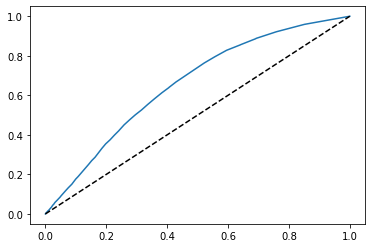

Area under curve (AUC):  0.6556524970302672


In [102]:
y_score = rfc2.predict_proba(x_test4)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)


plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

It looks like using just 4 most effective variables didn't change the accuracy much but it decrease the AUC significantly.

### XGBoost (Main Model)

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

XGBoost expects the inputs as and I decided to use MinMaxScaler in order to do so. To not cause data leak I scale them after dividing to train and test

In [34]:
# scale data
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(x_train)
X_test_sc = scaler.transform(x_test)

In [103]:
xgbc = xgb.XGBClassifier(objective="binary:logistic")

In [105]:
xgbc.fit(X_train_sc, y_train, verbose= True, early_stopping_rounds= 10, eval_set = [(X_test_sc, y_test)])

[0]	validation_0-error:0.12269
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.12269
[2]	validation_0-error:0.12269
[3]	validation_0-error:0.12269
[4]	validation_0-error:0.12269
[5]	validation_0-error:0.12269
[6]	validation_0-error:0.12269
[7]	validation_0-error:0.12269
[8]	validation_0-error:0.12269
[9]	validation_0-error:0.12269
[10]	validation_0-error:0.12269
Stopping. Best iteration:
[0]	validation_0-error:0.12269



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [106]:
score = xgbc.score(X_test_sc, y_test)
print(score)

0.8773057647398389


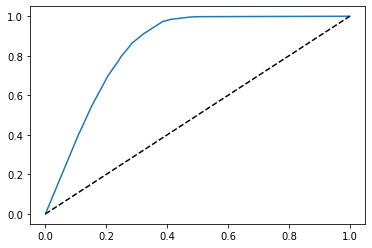

Area under curve (AUC):  0.8433367194982591


In [107]:
y_score = xgbc.predict_proba(X_test_sc)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)


plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

With default parameters XGBoost perfrom with 0.877 accuracy and 0.843 auc score. Which is already better than benchmark model.

### Optimizing the parameters

Next step is optimizing the Hyperparameters in order to achieve better results.

#### Learning rate

Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

In [37]:
X_val,X_test,Y_val,Y_test = train_test_split(x_test, y_test, random_state = 123, test_size = 0.5)

In [39]:
# scale date
scaler = MinMaxScaler()
X_val_sc = scaler.fit_transform(X_val)
X_test_sc = scaler.transform(X_test)


In [55]:
lr_list = [0.01, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    xgbcl = xgb.XGBClassifier(n_estimators=50, 
                                learning_rate=learning_rate, 
                                max_depth=3,
                                gamma = 1, random_state=123)
    xgbcl.fit(X_train_sc, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): ", xgbcl.score(X_train_sc, y_train))
    print("Accuracy score (validation): ", xgbcl.score(X_val_sc, Y_val))

Learning rate:  0.01
Accuracy score (training):  0.8773808000997091
Accuracy score (validation):  0.8780142216158064
Learning rate:  0.05
Accuracy score (training):  0.8773808000997091
Accuracy score (validation):  0.8780142216158064
Learning rate:  0.075
Accuracy score (training):  0.8773808000997091
Accuracy score (validation):  0.8780142216158064
Learning rate:  0.1
Accuracy score (training):  0.8773808000997091
Accuracy score (validation):  0.8780142216158064
Learning rate:  0.25
Accuracy score (training):  0.8774004795219212
Accuracy score (validation):  0.8780929390464696
Learning rate:  0.5
Accuracy score (training):  0.8776891110476996
Accuracy score (validation):  0.8782241347642413
Learning rate:  0.75
Accuracy score (training):  0.8778301469068868
Accuracy score (validation):  0.8779879824722521
Learning rate:  1
Accuracy score (training):  0.8777973478698665
Accuracy score (validation):  0.8779879824722521


Looks like 0.5 learning rate perform the best.

#### Max depth

The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.

In [57]:
md_list = [1,2,3,4,5,6]

for max_depth in md_list:
    xgbcl = xgb.XGBClassifier(n_estimators=50, 
                                learning_rate=0.5, 
                                max_depth=max_depth,
                                gamma = 1, random_state=123)
    xgbcl.fit(X_train_sc, y_train)

    print("max_depth: ", max_depth)
    print("Accuracy score (training): ", xgbcl.score(X_train_sc, y_train))
    print("Accuracy score (validation): ", xgbcl.score(X_val_sc, Y_val))

max_depth:  1
Accuracy score (training):  0.8773808000997091
Accuracy score (validation):  0.8780142216158064
max_depth:  2
Accuracy score (training):  0.8773283216404766
Accuracy score (validation):  0.8780666999029152
max_depth:  3
Accuracy score (training):  0.8776891110476996
Accuracy score (validation):  0.8782241347642413
max_depth:  4
Accuracy score (training):  0.8781679769881956
Accuracy score (validation):  0.8785127653433392
max_depth:  5
Accuracy score (training):  0.8790371514692329
Accuracy score (validation):  0.877463199601165
max_depth:  6
Accuracy score (training):  0.8804114311203823
Accuracy score (validation):  0.8772795255962845


We can see that max_depth 4 gave the best accuracy

#### Gamma

Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.

In [60]:
gm_list = [1,2,3,4,5,10,20]

for gamma in gm_list:
    xgbcl = xgb.XGBClassifier(n_estimators=50, 
                                learning_rate=0.5, 
                                max_depth=4,
                                gamma = gamma, random_state=123)
    xgbcl.fit(X_train_sc, y_train)

    print("Gamma: ", gamma)
    print("Accuracy score (training): ", xgbcl.score(X_train_sc, y_train))
    print("Accuracy score (validation): ", xgbcl.score(X_val_sc, Y_val))

Gamma:  1
Accuracy score (training):  0.8781679769881956
Accuracy score (validation):  0.8785127653433392
Gamma:  2
Accuracy score (training):  0.8782270152548322
Accuracy score (validation):  0.8780142216158064
Gamma:  3
Accuracy score (training):  0.87820733583262
Accuracy score (validation):  0.8785127653433392
Gamma:  4
Accuracy score (training):  0.8781515774696855
Accuracy score (validation):  0.8783290913384587
Gamma:  5
Accuracy score (training):  0.8780794195882409
Accuracy score (validation):  0.8780929390464696
Gamma:  10
Accuracy score (training):  0.87747919721077
Accuracy score (validation):  0.878197895620687
Gamma:  20
Accuracy score (training):  0.8774135991367293
Accuracy score (validation):  0.8780666999029152


Accuracy is higher with gamma value 3

#### Subsample

Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.

In [64]:
ss_list = [0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for subsample in ss_list:
    xgbcl = xgb.XGBClassifier(n_estimators=50, 
                              learning_rate=0.5, 
                              max_depth=4,
                              gamma = gamma, 
                              subsample = subsample,
                              random_state=123)
    xgbcl.fit(X_train_sc, y_train)

    print("Subsample: ", subsample)
    print("Accuracy score (training): ", xgbcl.score(X_train_sc, y_train))
    print("Accuracy score (validation): ", xgbcl.score(X_val_sc, Y_val))

Subsample:  0.25
Accuracy score (training):  0.8774660775959617
Accuracy score (validation):  0.8780929390464696
Subsample:  0.5
Accuracy score (training):  0.8773512809663908
Accuracy score (validation):  0.8779355041851434
Subsample:  0.6
Accuracy score (training):  0.8775710345144266
Accuracy score (validation):  0.87827661305135
Subsample:  0.7
Accuracy score (training):  0.8773808000997091
Accuracy score (validation):  0.8781454173335782
Subsample:  0.8
Accuracy score (training):  0.8775644747070226
Accuracy score (validation):  0.8783028521949043
Subsample:  0.9
Accuracy score (training):  0.8775152761514922
Accuracy score (validation):  0.878197895620687
Subsample:  1
Accuracy score (training):  0.8774135991367293
Accuracy score (validation):  0.8780666999029152


Best result is with 0.8

#### Min child weight

Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.

In [63]:
mcw_list = [1,3,5,10]

for min_child_weight in gm_list:
    xgbcl = xgb.XGBClassifier(n_estimators=50, 
                              learning_rate=0.5, 
                              max_depth=4,
                              gamma = 3, 
                              min_child_weight = min_child_weight,
                              subsample = 0.8,
                              random_state=123)
    xgbcl.fit(X_train_sc, y_train)

    print("min_child_weight: ", min_child_weight)
    print("Accuracy score (training): ", xgbcl.score(X_train_sc, y_train))
    print("Accuracy score (validation): ", xgbcl.score(X_val_sc, Y_val))

min_child_weight:  1
Accuracy score (training):  0.8781843765067058
Accuracy score (validation):  0.8778305476109259
min_child_weight:  2
Accuracy score (training):  0.8781548573733875
Accuracy score (validation):  0.8780929390464696
min_child_weight:  3
Accuracy score (training):  0.8780203813216044
Accuracy score (validation):  0.8785914827740022
min_child_weight:  4
Accuracy score (training):  0.8781482975659834
Accuracy score (validation):  0.8785127653433392
min_child_weight:  5
Accuracy score (training):  0.8779351038253517
Accuracy score (validation):  0.8787751567788827
min_child_weight:  10
Accuracy score (training):  0.877971182766074
Accuracy score (validation):  0.8780929390464696
min_child_weight:  20
Accuracy score (training):  0.8780630200697308
Accuracy score (validation):  0.8780666999029152


min_child_weight is best 1

Best parameters

learning_rate=0.5,  
max_depth=4,  
gamma = 3,   
min_child_weight = min_child_weight,  
subsample = 0.8,  

In [87]:
modelOP = xgb.XGBClassifier(objective='binary:logistic', 
                          seed = 123, 
                          gamma = 3,
                          learning_rate = 0.5,
                          max_depth = 4,
                          min_child_weight = 1,
                          subsample = 0.8)

In [88]:
modelOP.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [89]:
score = modelOP.score(X_test_sc, Y_test)
print(score)

0.8771483298785128


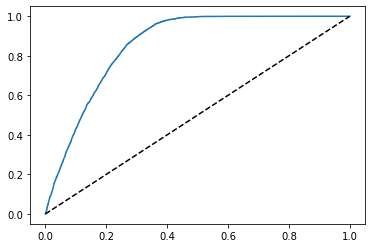

Area under curve (AUC):  0.8561586338314845


In [86]:
y_score = modelOP.predict_proba(X_test_sc)[:,1]
fpr, tpr, _ = roc_curve(Y_test, y_score)


plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

With Optimizing parameters manually XGBoost perfrom with 0.87714 accuracy and 0.8561 auc score.

### Grid Search CV

In [66]:
param_grid = {
        'learning_rate' : [0.01, 0.05, 0.1, 0.25, 0.5, 0.75],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [2, 3, 4],
        }
optimal_params = GridSearchCV(estimator = xgb.XGBClassifier(objective='binary:logistic', 
                                                            seed = 123, 
                                                            subsample = 0.9, 
                                                            colsample_bytree = 0.5),
                              param_grid = param_grid, 
                              scoring = 'roc_auc',
                              verbose = 2,
                              n_jobs = 10,
                              cv = 2
                             )

In [ ]:
optimal_params.fit(X_train_sc, y_train, early_stopping_rounds = 10, eval_metric = "auc", eval_set = [(X_val_sc, Y_val)], verbose = True)

In [71]:
optimal_params.best_params_

{'gamma': 5,
 'learning_rate': 0.25,
 'max_depth': 4,
 'min_child_weight': 1,
 'subsample': 1.0}

We can see that Grid Search CV found relatively different results with over 1600 combinations and took over an hour to finish computing.

In [75]:
modelCV = xgb.XGBClassifier(objective='binary:logistic', 
                  seed = 123, 
                  gamma = 5,
                  learning_rate = 0.25,
                  max_depth = 4,
                  min_child_weight = 1,
                  subsample = 1.0,
                  colsample_bytree = 0.5)

In [76]:
modelCV.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [81]:
scoreCV = modelCV.score(X_test_sc, Y_test)
print(scoreCV)

0.8772008081656215


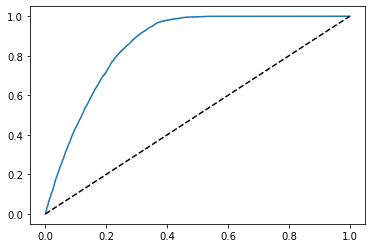

Area under curve (AUC):  0.8579750164479091


In [82]:
y_scoreCV = modelCV.predict_proba(X_test_sc)[:,1]
fpr, tpr, _ = roc_curve(Y_test, y_score)


plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))

With Grid Search CV parameters XGBoost perfrom with 0.8772 accuracy and 0.8579 auc score.

### Conclusion

| Model | Accuracy | AUC |
| --- | --- | --- |
| RF Base Model | 0.866 | 0.833 |
| RF Top 4 feature |0.862 | 0.655 |
| XGBoost Base | 0.8773 | 0.8433 |
| XGBoost Manual optimization | 0.8771 | 0.8561 |
| XGBoost Grid Search CV | 0.8772 | 0.8579 |

It is possible to see that XGBoost performed better than Random Forest with 1% more accuracy and 2.5% more AUC. It is possible to say that optimizing the parameters of XGBoost increase the performance of the model with around 1.5% AUC.   
  
If it comes to manual optimization and Grid Search CV there is not much performance difference between two methods. If one has enough computational power and doesn’t have much time or experience to try then can clearly choose Grid Search CV. But from other hand manual optimization is giving more understanding of the model, more freedom and it does not require as much computational power as Grid Search CV.


Random Forest	Accuracy	AUC
Base Model	0.866	0.833
Top 4 feature	0.862	0.655
XGBoost	Accuracy	AUC
Base	0.8773	0.8433
Manual optimization	0.8771	0.8561
Grid Search CV	0.8772	0.8579
